In [1]:
import os,requests
def download(url):
    get_response = requests.get(url,stream=True)
    file_name  = "data.zip"
    with open(file_name, 'wb') as f:
        for chunk in get_response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

download("https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10200/868375/upload/train_simplified.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1740703293&Signature=iYYMnj1UwM3zW6QFkRh10UFB7BF93vAALpkgiXxXEyTMV83Yoh%2BSM%2F8YBG53nf%2B3gOgtjKwOBVqLG1GeW9v8sIuum2hNj80E7D2UHg7VDkr6rDpCsOxeUk557eP1j%2B0djhVRSSc9cvaDo8rdxjDv97GZZajv7SVUvP1M1FNDfGoPp1HV7Ed3ktSKmopa%2FSgBkXImLvtmjM9LvDQHxyd%2BHbW7nGI7SRG2wADpsu8Gh1f1RH0naAQiNA8nMrcor2j08UN8bIDR18iLlU74q7%2FChm9TIS4wdiqaFSrPcamo44cACgcAib6iDYVceRN4ovjjLsJ52S5cYsk0xTWk18mVkw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain_simplified.zip")


In [2]:
import zipfile
with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

BadZipFile: File is not a zip file

In [ ]:
batch_size = 4096
STROKE_COUNT = 196
TRAIN_SAMPLES = 750
VALID_SAMPLES = 75
TEST_SAMPLES = 50

In [ ]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x,y): return top_k_categorical_accuracy(x,y, 3)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from glob import glob
import gc
gc.enable()
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
base_dir = os.path.join('.', './')
# test_path = os.path.join(base_dir, 'test_simplified.csv')

In [ ]:
from ast import literal_eval
ALL_TRAIN_PATHS = glob(os.path.join(base_dir, '*.csv'))
print(ALL_TRAIN_PATHS)
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

def _stack_it(raw_strokes):
    """preprocess the string and make
    a standard Nx3 stroke vector"""
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list
    in_strokes = [(xi,yi,i)
     for i,(x,y) in enumerate(stroke_vec)
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    return pad_sequences(c_strokes.swapaxes(0, 1),
                         maxlen=STROKE_COUNT,
                         padding='post').swapaxes(0, 1)
def read_batch(samples=5,
               start_row=0,
               max_rows = 1000):
    """
    load and process the csv files
    this function is horribly inefficient but simple
    """
    out_df_list = []
    for c_path in ALL_TRAIN_PATHS:
        c_df = pd.read_csv(c_path, nrows=max_rows, skiprows=start_row)
        c_df.columns=COL_NAMES
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].\
        map(_stack_it)

    return full_df

['././pear.csv', '././tornado.csv', '././sleeping bag.csv', '././stairs.csv', '././face.csv', '././school bus.csv', '././squirrel.csv', '././microwave.csv', '././shovel.csv', '././spreadsheet.csv', '././hamburger.csv', '././star.csv', '././bush.csv', '././square.csv', '././horse.csv', '././bird.csv', '././bee.csv', '././garden.csv', '././helmet.csv', '././table.csv', '././map.csv', '././calendar.csv', '././scorpion.csv', '././guitar.csv', '././lighthouse.csv', '././snowflake.csv', '././parrot.csv', '././traffic light.csv', '././snowman.csv', '././alarm clock.csv', '././flip flops.csv', '././matches.csv', '././fence.csv', '././rainbow.csv', '././grapes.csv', '././pliers.csv', '././computer.csv', '././television.csv', '././spoon.csv', '././sandwich.csv', '././parachute.csv', '././paintbrush.csv', '././book.csv', '././anvil.csv', '././pond.csv', '././flower.csv', '././tiger.csv', '././grass.csv', '././sink.csv', '././bowtie.csv', '././spider.csv', '././giraffe.csv', '././ear.csv', '././tr

In [ ]:
train_args = dict(samples=TRAIN_SAMPLES,
                  start_row=0,
                  max_rows=int(TRAIN_SAMPLES*1.5))
valid_args = dict(samples=VALID_SAMPLES,
                  start_row=train_args['max_rows']+1,
                  max_rows=VALID_SAMPLES+25)
test_args = dict(samples=TEST_SAMPLES,
                 start_row=valid_args['max_rows']+train_args['max_rows']+1,
                 max_rows=TEST_SAMPLES+25)
train_df = read_batch(**train_args)
valid_df = read_batch(**valid_args)
test_df = read_batch(**test_args)
word_encoder = LabelEncoder()
word_encoder.fit(train_df['word'])
print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))


words 340 => The Eiffel Tower, The Great Wall of China, The Mona Lisa, airplane, alarm clock, ambulance, angel, animal migration, ant, anvil, apple, arm, asparagus, axe, backpack, banana, bandage, barn, baseball, baseball bat, basket, basketball, bat, bathtub, beach, bear, beard, bed, bee, belt, bench, bicycle, binoculars, bird, birthday cake, blackberry, blueberry, book, boomerang, bottlecap, bowtie, bracelet, brain, bread, bridge, broccoli, broom, bucket, bulldozer, bus, bush, butterfly, cactus, cake, calculator, calendar, camel, camera, camouflage, campfire, candle, cannon, canoe, car, carrot, castle, cat, ceiling fan, cell phone, cello, chair, chandelier, church, circle, clarinet, clock, cloud, coffee cup, compass, computer, cookie, cooler, couch, cow, crab, crayon, crocodile, crown, cruise ship, cup, diamond, dishwasher, diving board, dog, dolphin, donut, door, dragon, dresser, drill, drums, duck, dumbbell, ear, elbow, elephant, envelope, eraser, eye, eyeglasses, face, fan, feathe

In [ ]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X.shape)

(255000, 196, 3)


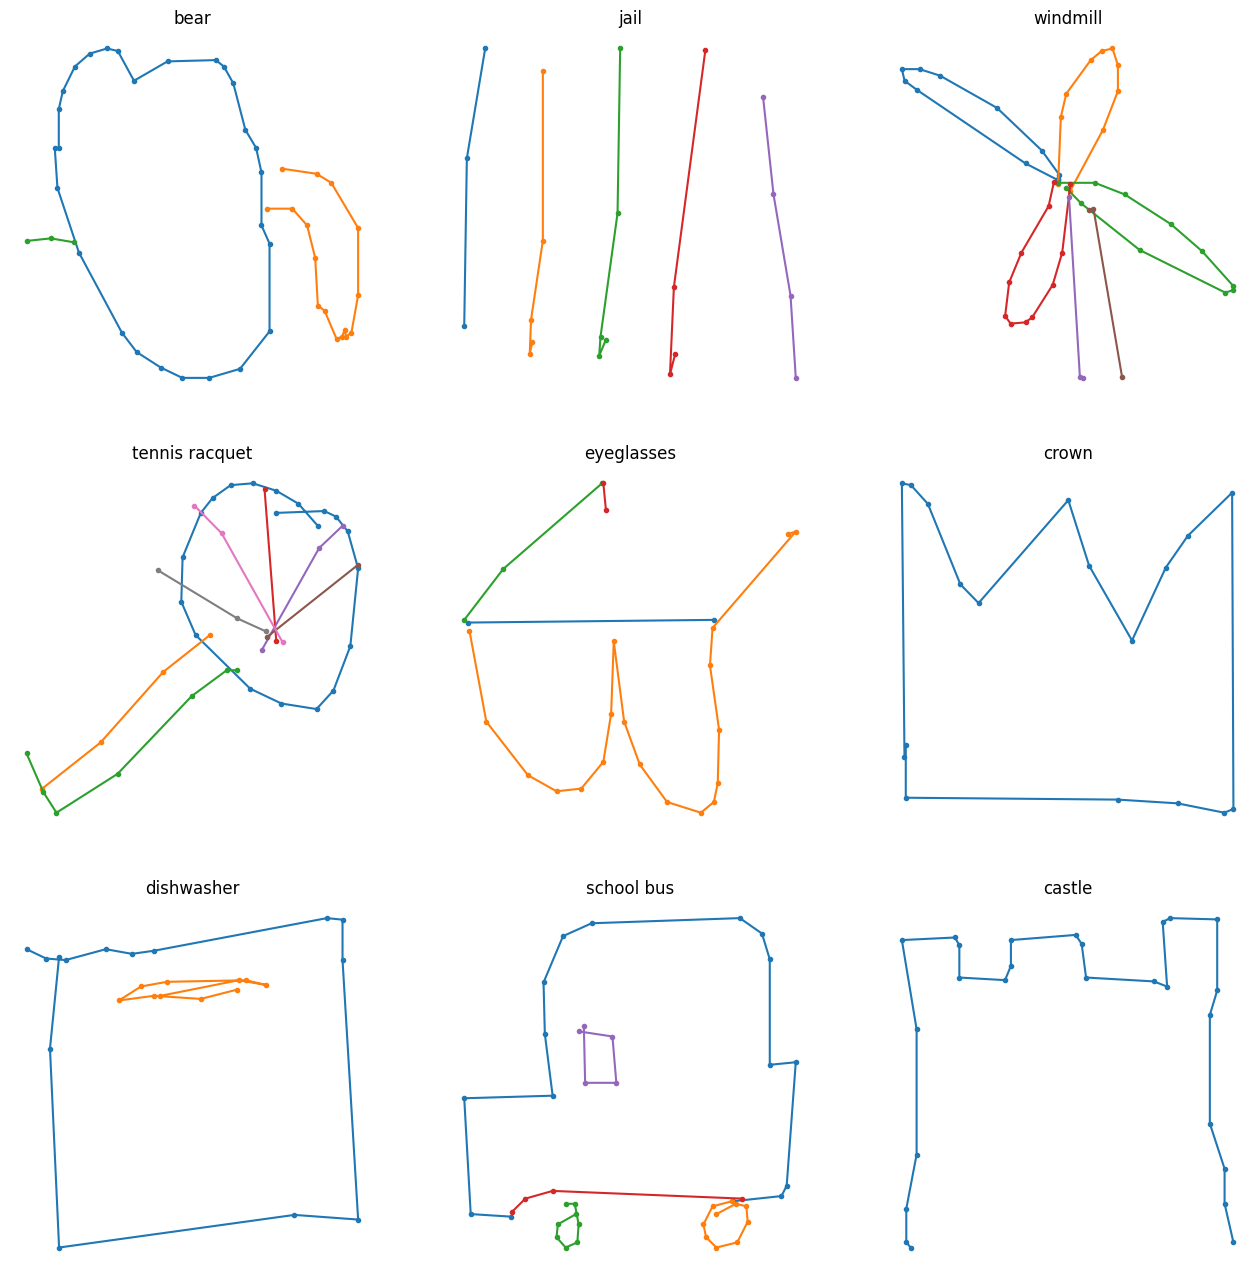

In [ ]:
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(train_X.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = train_X[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0],
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(word_encoder.classes_[np.argmax(train_y[c_id])])


In [ ]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, LSTM, Dense, Dropout
if len(get_available_gpus())>0:
    # https://twitter.com/fchollet/status/918170264608817152?lang=en
    from keras.layers import LSTM # this one is about 3x faster on GPU instances
stroke_read_model = Sequential()
stroke_read_model.add(BatchNormalization(input_shape = (None,)+train_X.shape[2:]))
# filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
stroke_read_model.add(Conv1D(48, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(64, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(96, (3,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences=True, recurrent_activation="sigmoid"))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences=False, recurrent_activation="sigmoid"))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(512))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(len(word_encoder.classes_), activation = 'softmax'))
stroke_read_model.compile(optimizer = 'adam',
                          loss = 'categorical_crossentropy',
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, None, 3)             │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, None, 48)            │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 64)            │          15,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, None, 96)            │          18,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 128)           │         115,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 340)                 │         174,420 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 521,984 (1.99 MB)

 Trainable params: 521,978 (1.99 MB)

 Non-trainable params: 6 (24.00 B)

In [ ]:
weight_path="{}.weights.h5".format('stroke_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10,
                                   verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]


In [ ]:
from IPython.display import clear_output
stroke_read_model.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y),
                      batch_size = batch_size,
                      epochs = 50,
                      callbacks = callbacks_list)
clear_output()

Epoch 1/50


In [ ]:
import os,requests
def download(url):
    get_response = requests.get(url,stream=True)
    file_name  = "test_csv.zip"
    with open(file_name, 'wb') as f:
        for chunk in get_response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

download("https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10200/868375/compressed/test_simplified.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1740704467&Signature=g6BHgHelik2Rym9DhfhmCFXVXbUTe5XsiikptDLxHF3b2dcJ8rYLBC2t1mmQiTn%2Fx3QMEMRPoARW98wUN6J%2BtEMhx9S6FM%2Bc8q43jKzSuaZpcZSFiSpTr0j1%2Fw8D34zxBwJ%2BIINF%2BF72ArpafYy8zvGHbmhXkdmZUI4pUx%2FoC4ZeDMT16G%2BwGOX9s01WQFGwMTv3FBrW%2BIzcETGD9NSwpDh7eA%2BXz34KGPpNN0sM8Qj9LkCczgZsPbR4mbuOlPcGLNM%2BIFDAMMltr86xEUUJUmdsyalfSicgR%2F7bwn3GZfexIVfzUqGCA2sW4lY1omPjnLsUPetyc9ijKFnHZAjf8A%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest_simplified.csv.zip")


In [ ]:
import zipfile
with zipfile.ZipFile('./test_csv.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
test_path = os.path.join(base_dir, 'test_simplified.csv')